In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim


In [2]:
pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('m4', 'outputs')
data_formatter = config.make_data_formatter()


print("*** Training from defined parameters for {} ***".format('m4'))
data_csv_path = 'data/m4_subset.csv'
print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)
train, valid, test = data_formatter.split_data(raw_data)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
)

# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = 'cpu'

*** Training from defined parameters for m4 ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...


In [5]:
max_samples = 1000
elect = ts_dataset.TSDataset(fixed_params, max_samples, train)

Getting valid sampling locations.
Extracting 1000 samples...


In [6]:
batch_size=64
loader = DataLoader(
            elect,
            batch_size=batch_size,
            num_workers=2,
            shuffle=False
        )

In [7]:
for batch in loader:
    break

In [8]:
model = tft_model.TFT(fixed_params)

{'total_time_steps': 54, 'num_encoder_steps': 36, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('time', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('value', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('time_cat', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('category', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 3, 'output_size': 1, 'category_counts': [1], 'input_obs_loc': [0], 'static_input_loc': [2], 'known_regular_inputs': [1], 'known_categorical_inputs': [0], 'dropout_rate': 0.1, 'hidden_layer_size': 160, 'learning_rate': 0.001, 'minibatch_size': 64, 'max_gradient_norm': 0.01, 'num_heads': 4, 'stack_size': 1, 'batch_first': True, 'name': 'test', 'device': 'cpu'}
54
3
1
2


In [9]:
q_loss_func = tft_model.QuantileLoss([0.1,0.5,0.9])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
model.train()
epochs=100
losses = []
for i in range(epochs):
    epoch_loss = [] 
    j=0
    for batch in loader:
        output, all_inputs, attention_components = model(batch['inputs'])
        loss= q_loss_func(output[:,:,:].view(-1,3), batch['outputs'][:,:,0].flatten().float())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        j+=1
        if j>5:
            break
    losses.append(np.mean(epoch_loss))
    print(np.mean(epoch_loss))
    

/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/tft_model.py:387: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(-1)
/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/tft_model.py:339: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(2)


1.1635963718096416
0.8297716379165649
0.8271889686584473
0.8842926919460297
0.9311377207438151
0.9873716135819753


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/ardakeskiner/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/ardakeskiner/anaconda

KeyboardInterrupt: 

In [11]:
output, all_inputs, attention_components = model(batch['inputs'])

/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/tft_model.py:387: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(-1)
/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/Temporal_Fusion_Transform/tft_model.py:339: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sparse_weights = self.softmax(sparse_weights).unsqueeze(2)


2


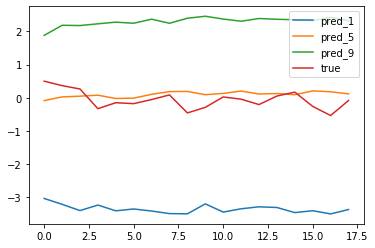

In [21]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [48]:
attn_weights.shape

NameError: name 'attn_weights' is not defined

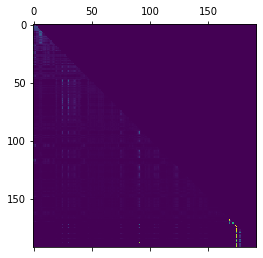

In [225]:
plt.matshow(attn_weights.detach().numpy()[0,:,:])

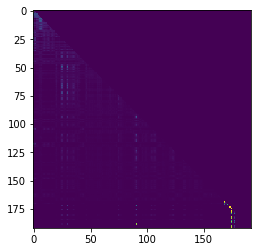

In [226]:
plt.imshow(attn_weights.detach().numpy()[0,:,:])

In [29]:
data_formatter._target_scaler[1]

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
batch['identifier'].detach().cpu().numpy().shape

(64, 54, 1)

In [32]:
batch['outputs'].detach().cpu().numpy()[0][:,0]

array([1.02518669, 0.56116285, 0.86864852, 0.79597009, 0.57234415,
       0.62825063, 0.47171247, 1.34944431, 1.13699966, 1.41653209,
       1.3829882 , 1.08668382, 1.04754928, 0.70651971, 1.66252063,
       1.62897674, 1.58425155, 1.47802923])

In [33]:
data_formatter._target_scaler[1].inverse_transform(batch['outputs'].detach().cpu().numpy()[0][:,0])

array([8140., 7310., 7860., 7730., 7330., 7430., 7150., 8720., 8340.,
       8840., 8780., 8250., 8180., 7570., 9280., 9220., 9140., 8950.])